In [1]:
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
from pypsa.descriptors import get_switchable_as_dense as as_dense

regions_fn = "../pypsa-eur/resources/20240826-z1/regions_onshore_base_s_115.geojson"
matplotlibrc_fn = "../pypsa-eur/matplotlibrc"
# config_fn = "../pypsa-eur/config/config.default.yaml"
# gem_fn = "../pypsa-eur/data/gem/Global-Steel-Plant-Tracker-April-2024-Standard-Copy-V1.xlsx"
n_rel_fn = "../pypsa-eur/results/20240826-z1/postnetworks/base_s_115_lvopt___2050.nc"
n_fix_fn = "../pypsa-eur/results/20240826-z1/postnetworks/base_s_115_lvopt__norelocation_2050.nc"
industry_fn = "../pypsa-eur/resources/20240826-z1/industrial_energy_demand_base_s_115_2050.csv"

OUTPUT = "20240826-z1/"

plt.style.use(matplotlibrc_fn)
crs = ccrs.EqualEarth()

In [2]:
industry_demand = pd.read_csv(industry_fn, index_col=[0,1]).groupby(level="node").sum()
gas_demand = industry_demand["methane"]
bio_demand = industry_demand["solid biomass"]
liquids_demand = industry_demand[["naphtha", "methanol"]].sum(axis=1)

In [3]:
regions = gpd.read_file(regions_fn).set_index("name")
n_fix = pypsa.Network(n_fix_fn)
n_rel = pypsa.Network(n_rel_fn)

INFO:pypsa.io:Imported network base_s_115_lvopt__norelocation_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_115_lvopt___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
regions.explore()

In [209]:
dri_i = n_fix.links.query("carrier == 'DRI'").index
weights = n_fix.snapshot_weightings.generators
dri_fix = (weights @ n_fix.links_t.p0.loc[:, dri_i]).rename(index=n_fix.links.loc[dri_i, "bus0"])
dri_fix /= dri_fix.sum() / 100

In [210]:
dri_i = n_rel.links.query("carrier == 'DRI'").index
weights = n_fix.snapshot_weightings.generators
dri_rel = (weights @ n_rel.links_t.p0.loc[:, dri_i]).rename(index=n_rel.links.loc[dri_i, "bus0"])
dri_rel /= dri_rel.sum() / 100

In [211]:
hb_i = n_fix.links.query("carrier == 'Haber-Bosch'").index
weights = n_fix.snapshot_weightings.generators
hb_fix = (weights @ n_fix.links_t.p0.loc[:, hb_i]).rename(index=n_fix.links.loc[hb_i, "bus0"])
hb_fix /= hb_fix.sum() / 100

In [212]:
hb_i = n_rel.links.query("carrier == 'Haber-Bosch'").index
weights = n_rel.snapshot_weightings.generators
hb_rel = (weights @ n_rel.links_t.p0.loc[:, hb_i]).rename(index=n_rel.links.loc[hb_i, "bus0"])
hb_rel /= hb_rel.sum() / 100

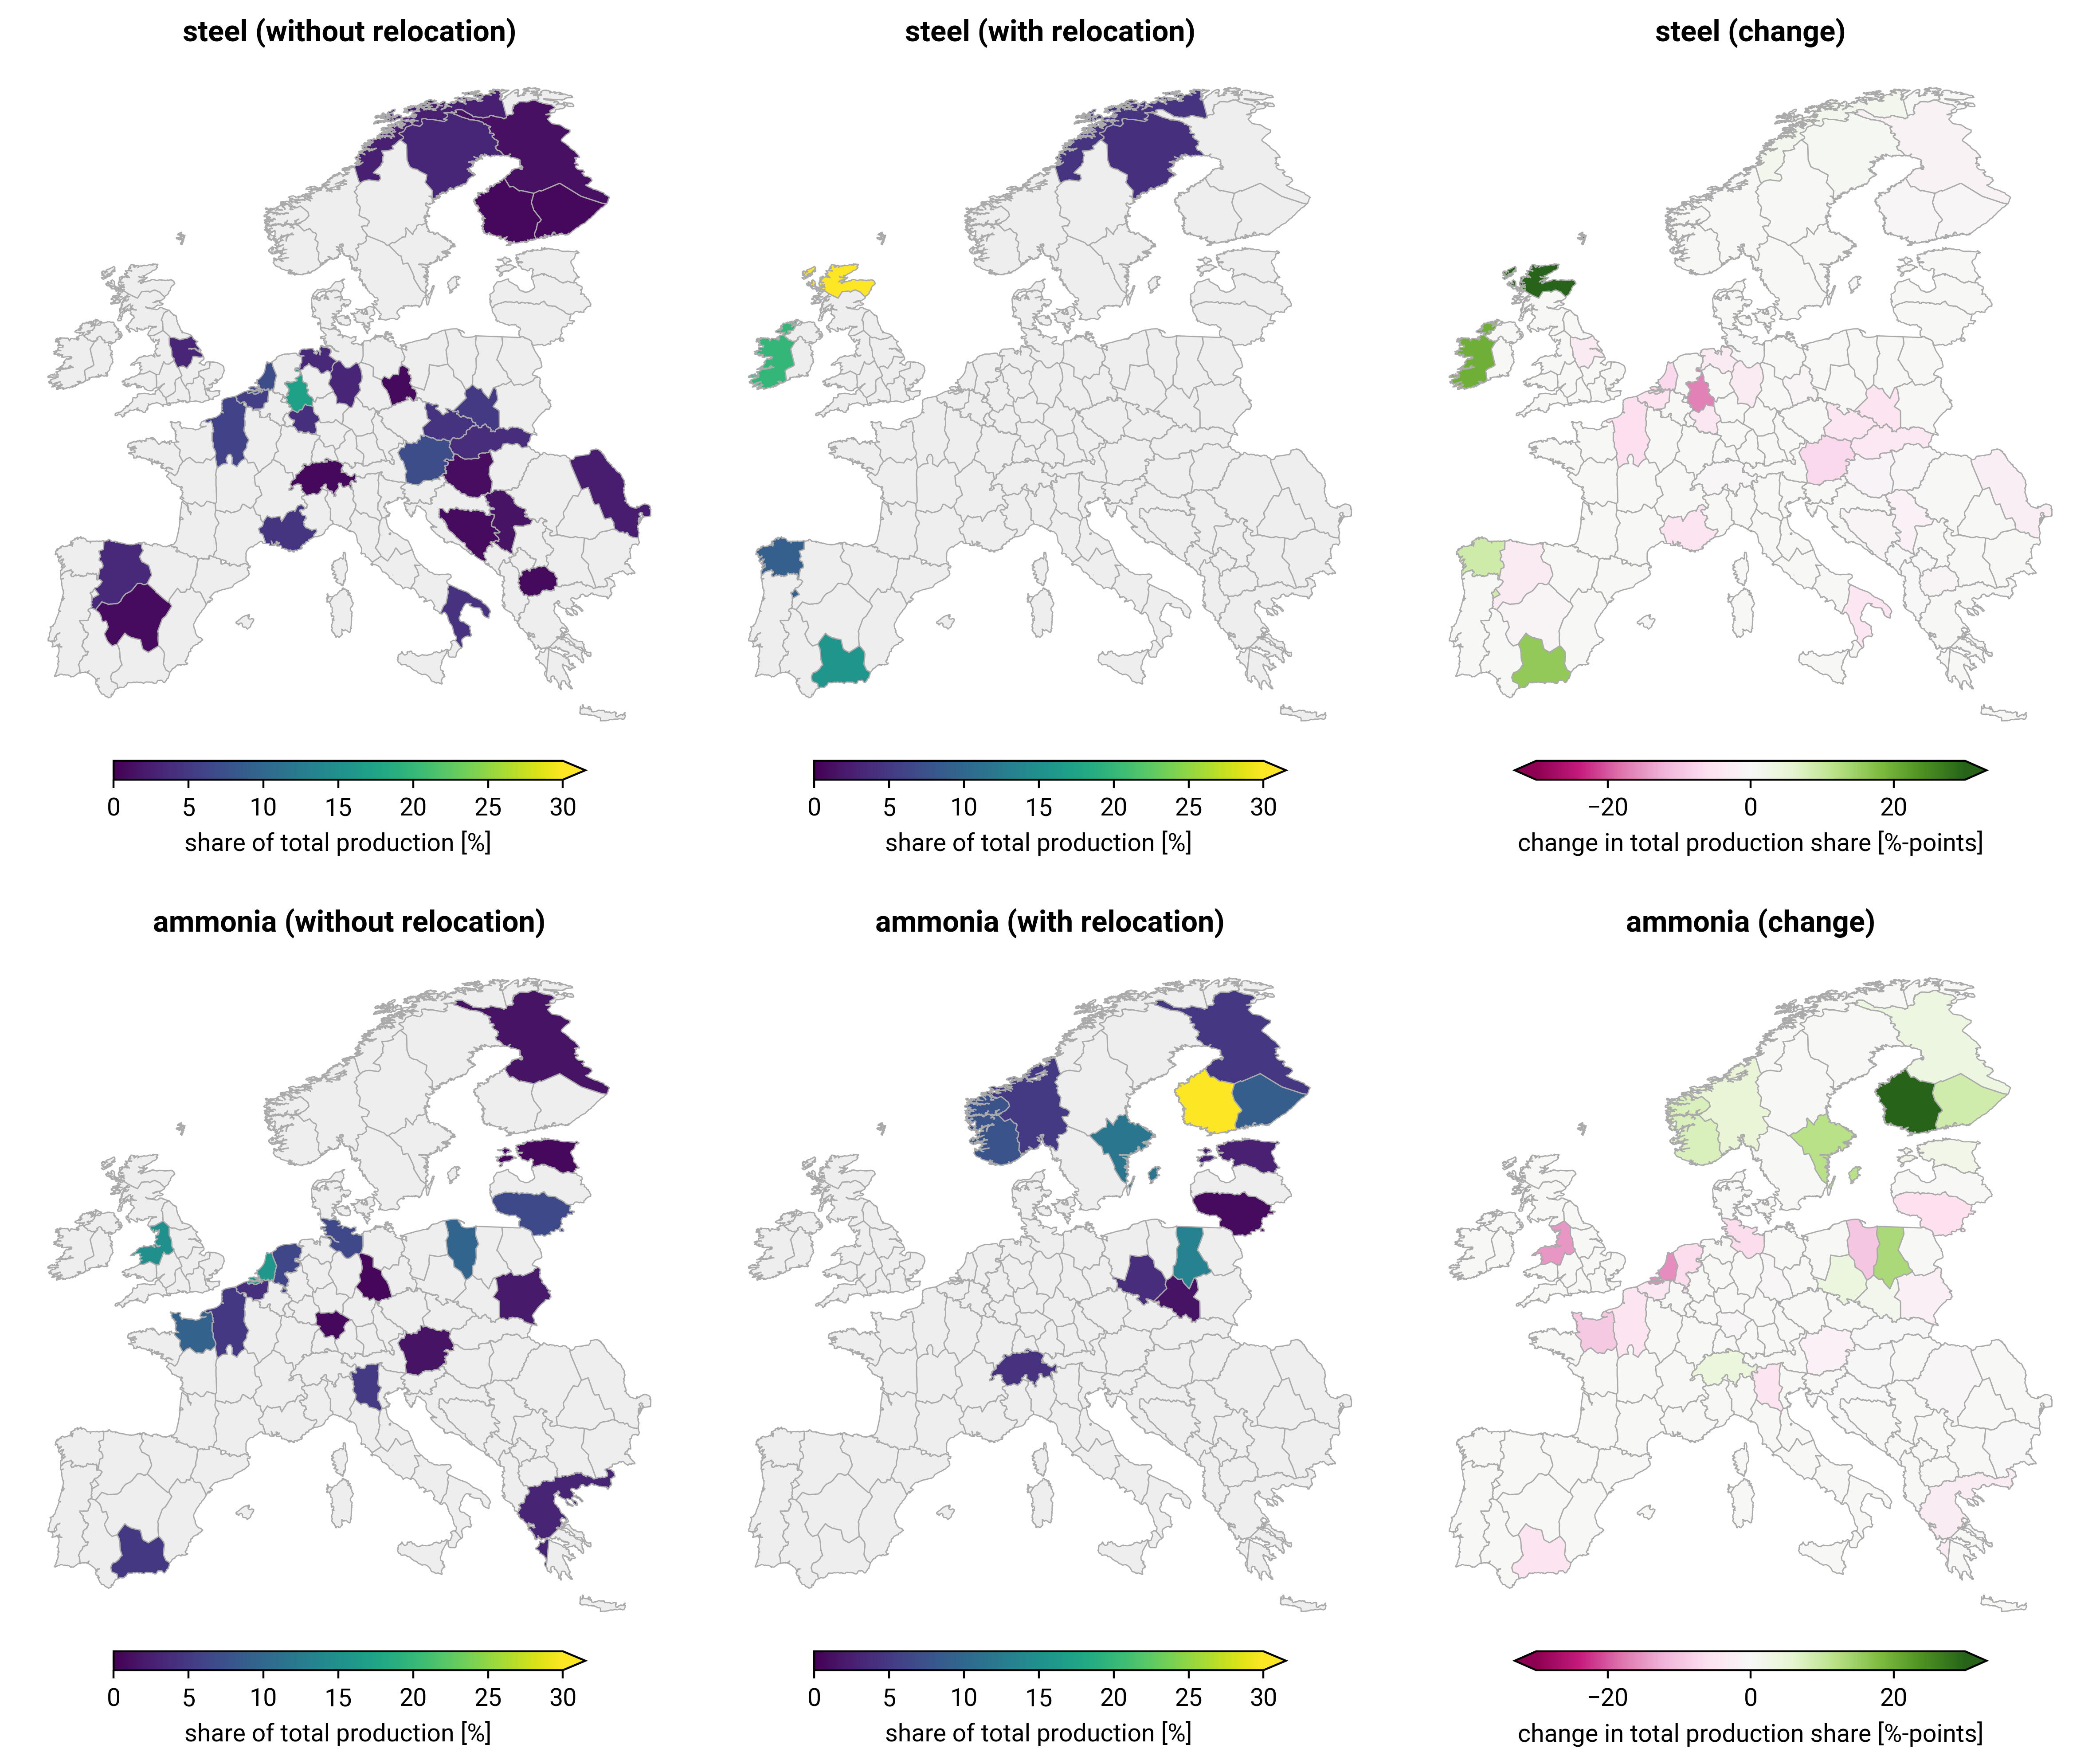

In [233]:
fig, axs = plt.subplots(
    2,
    3,
    subplot_kw={"projection": crs},
    figsize=(12, 10),
)
plt.subplots_adjust(wspace=0, hspace=0, right=0.1, left=0.05)

kwargs = dict(
    linewidths=0.5,
    edgecolor="#aaa",
    missing_kwds=dict(color="#eee"), 
)

abs_kwargs = dict(
    cmap="viridis",
    vmin=0,
    vmax=30,
    legend=True,
    legend_kwds=dict(
        label="share of total production [%]",
        orientation="horizontal",
        extend="max",
        shrink=0.7,
        aspect=25,
        pad=0.01,
    ),
)

rel_kwargs = dict(
    legend=True,
    legend_kwds=dict(
        label="change in total production share [%-points]",
        orientation="horizontal",
        extend="both",
        shrink=0.7,
        aspect=25,
        pad=0.01,
    ),
)

regions_eqearth = regions.to_crs(crs.proj4_init)

regions_eqearth.plot(ax=axs[0,0], column=dri_fix.where(dri_fix > 0.5), **abs_kwargs, **kwargs)
regions_eqearth.plot(ax=axs[0,1], column=dri_rel.where(dri_rel > 0.5), **abs_kwargs, **kwargs)
regions_eqearth.plot(ax=axs[0,2], column=dri_rel - dri_fix, cmap="PiYG", vmin=-30, vmax=30, **rel_kwargs, **kwargs)
regions_eqearth.plot(ax=axs[1,0], column=hb_fix.where(hb_fix > 0.5), **abs_kwargs, **kwargs)
regions_eqearth.plot(ax=axs[1,1], column=hb_rel.where(hb_rel > 0.5), **abs_kwargs, **kwargs)
regions_eqearth.plot(ax=axs[1,2], column=hb_rel - hb_fix, cmap="PiYG", vmin=-30, vmax=30, **rel_kwargs, **kwargs)

axs[0,0].set_title("steel (without relocation)", fontweight="bold")
axs[0,1].set_title("steel (with relocation)", fontweight="bold")
axs[0,2].set_title("steel (change)", fontweight="bold")
axs[1,0].set_title("ammonia (without relocation)", fontweight="bold")
axs[1,1].set_title("ammonia (with relocation)", fontweight="bold")
axs[1,2].set_title("ammonia (change)", fontweight="bold")

plt.tight_layout(h_pad=4)

for ax_row in axs:
    for ax in ax_row:
        for spine in ax.spines.values():
            spine.set_visible(False)

# fig.canvas.draw()

for ext in [".pdf", ".png"]:
    plt.savefig(
        OUTPUT + "industry-relocation" + ext,
        dpi=fig.dpi,
    )

In [223]:
n = n_rel
weights = n.snapshot_weightings.generators
demands =(weights @ as_dense(n, "Load", "p_set").groupby([n.loads.carrier, n.loads.bus.map(n.buses.location)], axis=1).sum()).div(1e6).unstack("carrier")

h2_carriers = ["H2 for industry"]
h2_demand = demands[h2_carriers].sum(axis=1).reindex(index=regions.index)
elec_carriers = ["agriculture electricity", "industry electricity", "land transport EV", "electricity"]
elec_demand = demands[elec_carriers].sum(axis=1).reindex(index=regions.index)
heat_carriers = ["urban central heat", "urban decentral heat", "rural heat", "low-temperature heat for industry", "agriculture heat"]
heat_demand = demands[heat_carriers].sum(axis=1).reindex(index=regions.index)

/tmp/ipykernel_48589/2839439286.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



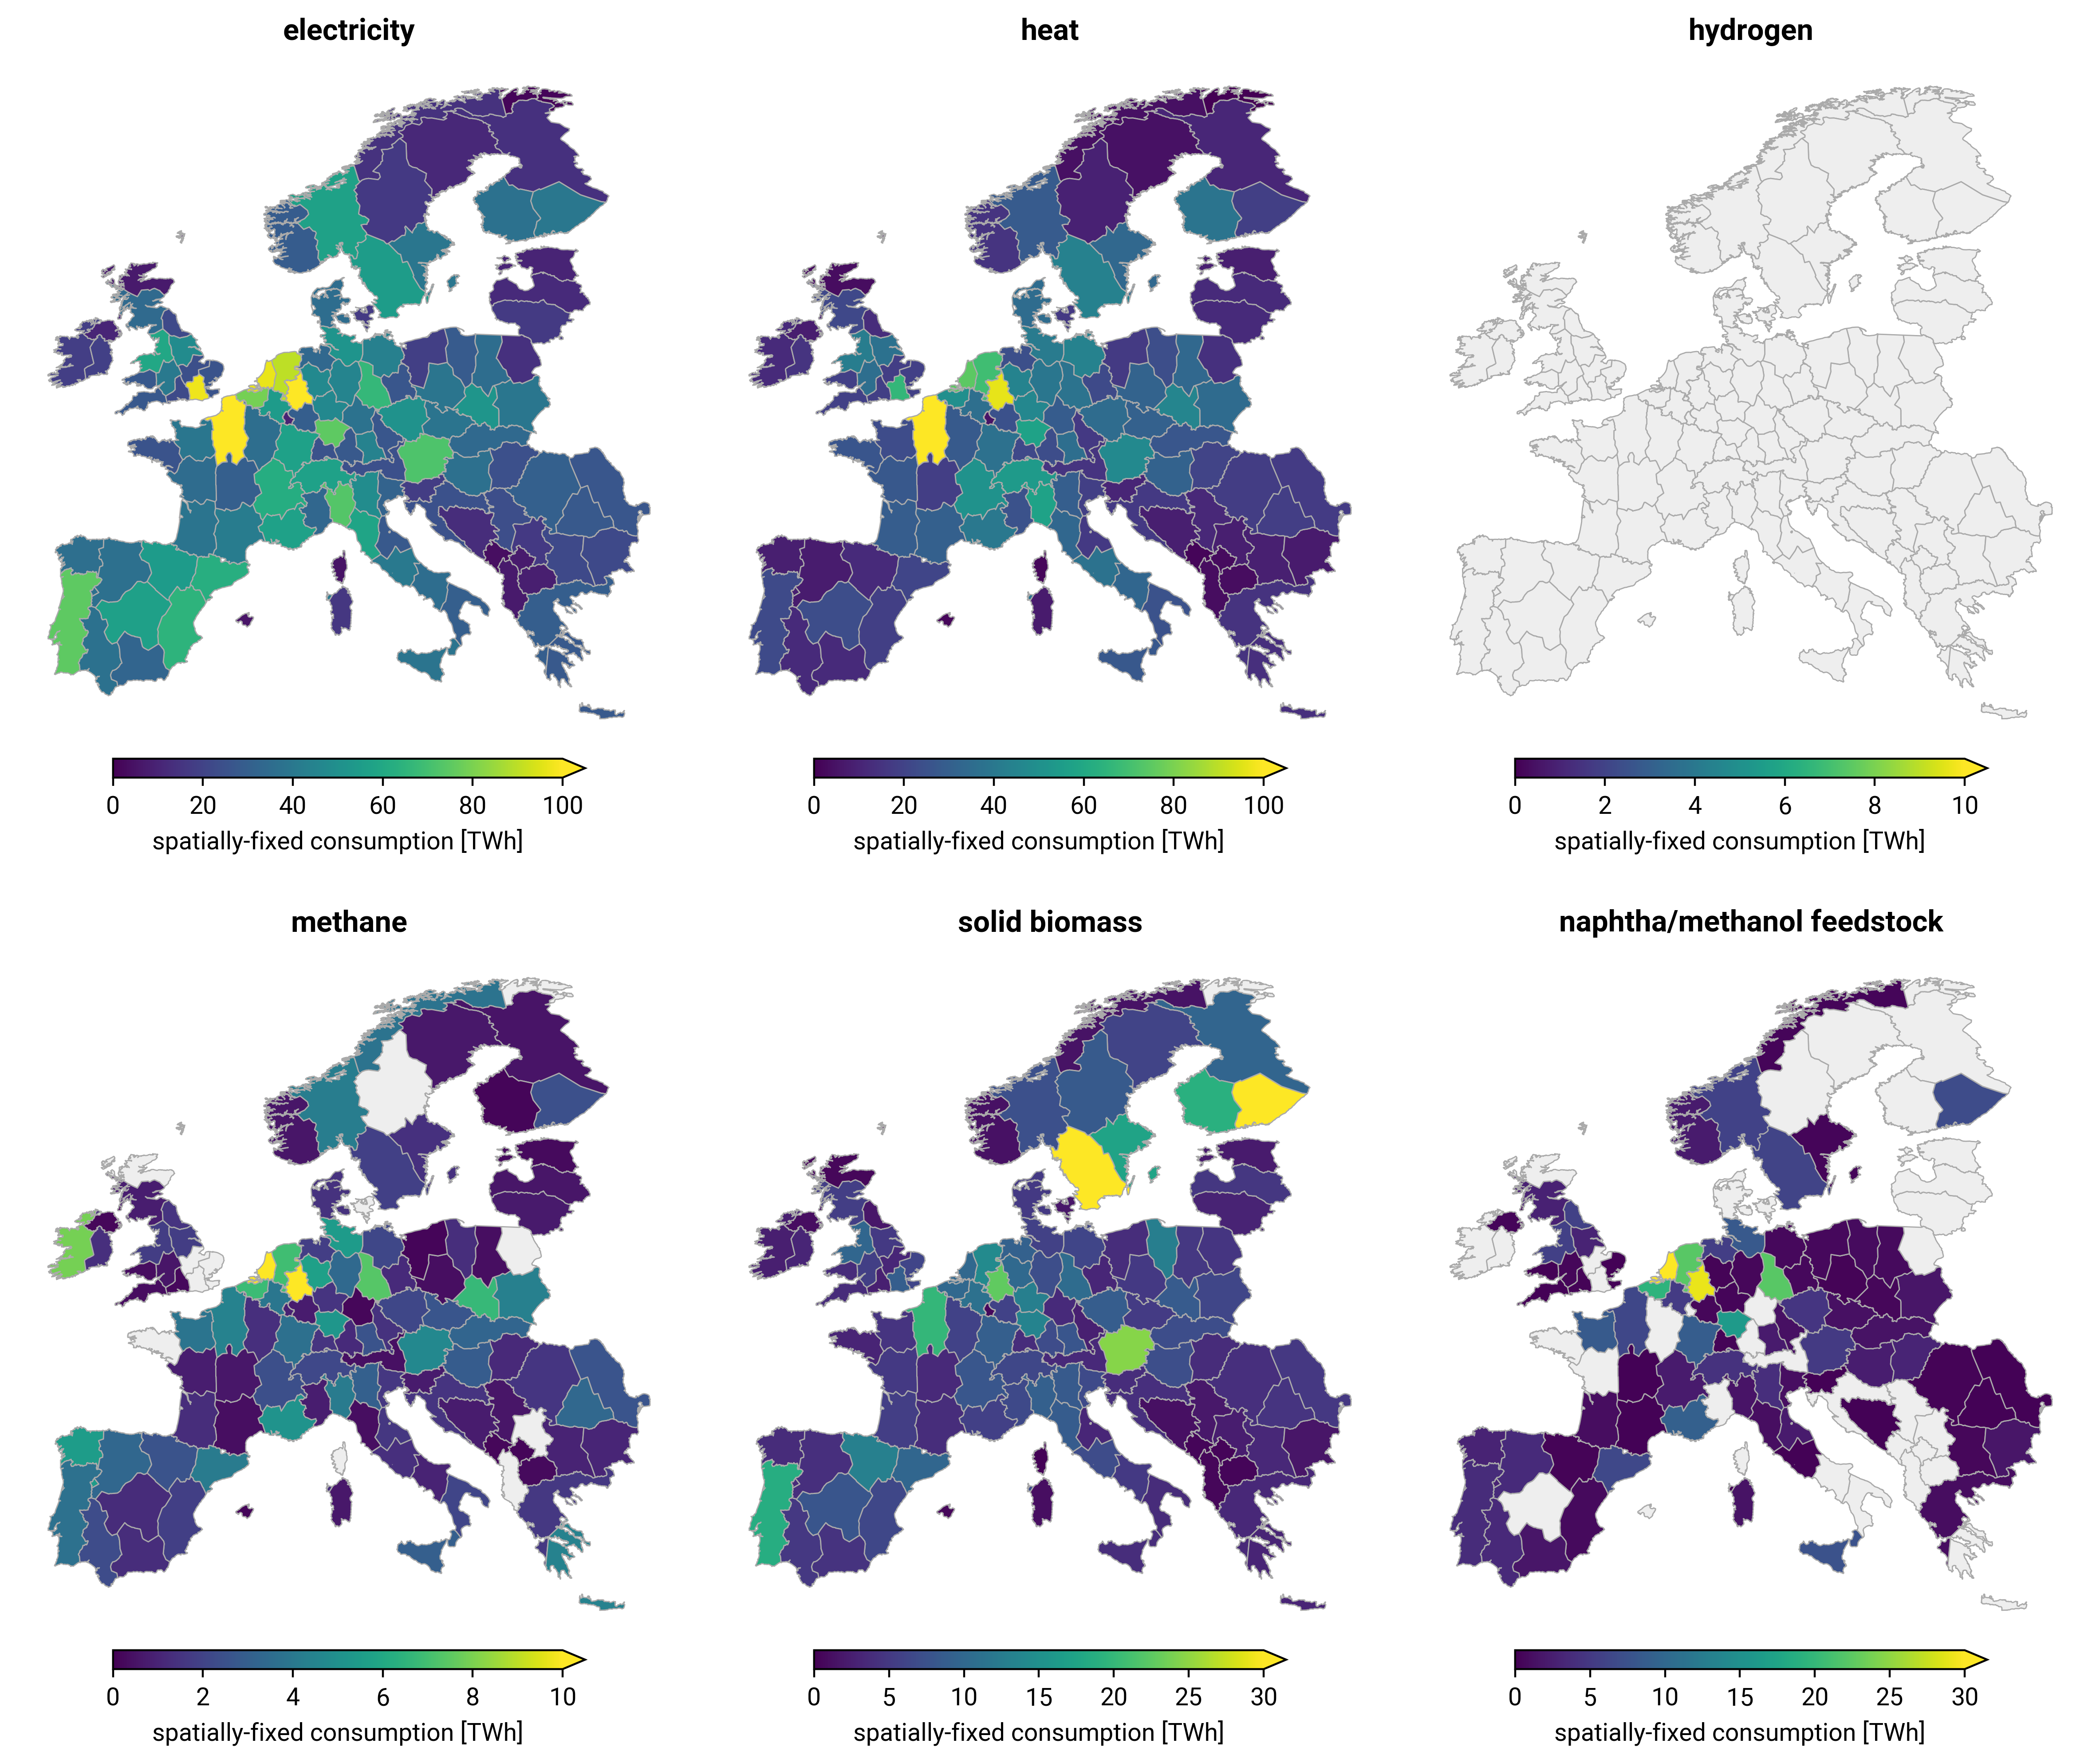

In [234]:
fig, axs = plt.subplots(
    2,
    3,
    subplot_kw={"projection": crs},
    figsize=(12, 10),
)
plt.subplots_adjust(wspace=0, hspace=0, right=0.1, left=0.05)

cmap = "viridis"

kwargs = dict(
    linewidths=0.5,
    edgecolor="#aaa",
    missing_kwds=dict(color="#eee"),
    cmap=cmap,
    legend=True,
    vmin=0,
    legend_kwds=dict(
        label="spatially-fixed consumption [TWh]",
        orientation="horizontal",
        extend="max",
        shrink=0.7,
        aspect=25,
        pad=0.01,
    ),
)

regions_eqearth = regions.to_crs(crs.proj4_init)

regions_eqearth.plot(ax=axs[0,0], column=elec_demand.where(elec_demand > 0.1), vmax=100, **kwargs)
regions_eqearth.plot(ax=axs[0,1], column=heat_demand.where(heat_demand > 0.1), vmax=100, **kwargs)
regions_eqearth.plot(ax=axs[0,2], column=h2_demand.where(h2_demand > 0.1), vmax=10, **kwargs)
regions_eqearth.plot(ax=axs[1,0], column=gas_demand.where(gas_demand > 0.1), vmax=10, **kwargs)
regions_eqearth.plot(ax=axs[1,1], column=bio_demand.where(bio_demand > 0.1), vmax=30, **kwargs)
regions_eqearth.plot(ax=axs[1,2], column=liquids_demand.where(liquids_demand > 0.1), vmax=30, **kwargs)

axs[0,0].set_title("electricity", fontweight='bold')
axs[0,1].set_title("heat", fontweight='bold')
axs[0,2].set_title("hydrogen", fontweight='bold')
axs[1,0].set_title("methane", fontweight='bold')
axs[1,1].set_title("solid biomass", fontweight='bold')
axs[1,2].set_title("naphtha/methanol feedstock", fontweight='bold')

plt.tight_layout(h_pad=4)

for ax_row in axs:
    for ax in ax_row:
        for spine in ax.spines.values():
            spine.set_visible(False)

fig.canvas.draw()

for ext in [".pdf", ".png"]:
    plt.savefig(
        OUTPUT + "fixed-demand" + ext,
        dpi=fig.dpi,
    )